## Download the dataset from the following link before using this notebook (Pavia Centre scene):

##  https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

## Import required libraries

In [1]:
import numpy as np
import h5py
import random
from scipy.io import loadmat
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU available. Using:", gpus[0])
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("❌ GPU not available. Running on CPU.")

2025-08-01 11:07:59.890550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 11:07:59.916259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754035679.931957 2036896 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754035679.937052 2036896 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 11:07:59.954816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

✅ GPU available. Using: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


##  Reproducibility Setup ( Set a consistent random seed for NumPy, TensorFlow, and Python's random module to ensure the same results on each run)

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

##  Load the PaviaC Dataset

In [3]:
data = loadmat("Pavia.mat")
if 'pavia' not in data:
    raise KeyError("'pavia' not found in the .mat file.")
hyperspectral_image = data['pavia'].astype(np.float32)

##  Parameter Initialization for dataset preprocessing only

In [4]:
patch_size = (144, 144)
downscale_factor = 8
nodata_value = -1
group_size = 32
overlap_size = 8
validation_ratio = 0.1

## Define Test Patch (Bottom-Center)

In [5]:
H, W, _ = hyperspectral_image.shape
patch_h, patch_w = patch_size
test_i = H - patch_h
test_j = (W - patch_w) // 2
test_coords = (test_i, test_j)

# Extract test patch
test_hr_full = hyperspectral_image[test_i:test_i + patch_h, test_j:test_j + patch_w, :]
test_lr_full = tf.image.resize(test_hr_full,
                               size=(patch_h // downscale_factor, patch_w // downscale_factor),
                               method='area').numpy()
test_hr_full = test_hr_full[np.newaxis, ...]
test_lr_full = test_lr_full[np.newaxis, ...]



I0000 00:00:1754035684.160926 2036896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


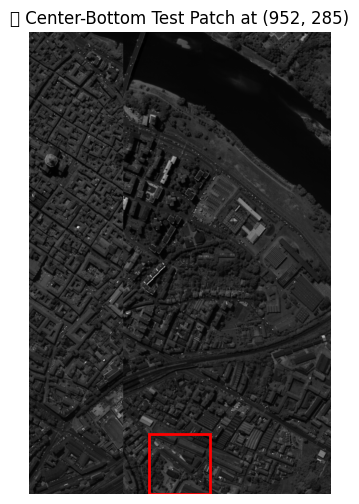

In [6]:
# -----------------------------
# Visualize test patch
# -----------------------------
plt.figure(figsize=(6, 6))
plt.imshow(np.mean(hyperspectral_image, axis=-1), cmap='gray')
plt.gca().add_patch(plt.Rectangle((test_j, test_i), patch_w, patch_h,
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.title(f"📍 Center-Bottom Test Patch at {test_coords}")
plt.axis('off')
plt.show()

## Extract Training Patches

In [7]:
def extract_training_patches(data, patch_size, downscale_factor, nodata_value, test_coords):
    h, w, b = data.shape
    i_test, j_test = test_coords
    patch_h, patch_w = patch_size
    train_hr, train_lr = [], []

    for i in range(0, h - patch_h + 1, patch_h):
        for j in range(0, w - patch_w + 1, patch_w):
            if i == i_test and j == j_test:
                continue  # avoid test patch
            patch = data[i:i + patch_h, j:j + patch_w, :]
            if patch.shape[:2] != patch_size or np.any(patch == nodata_value):
                continue
            patch_lr = tf.image.resize(patch,
                                       size=(patch_h // downscale_factor, patch_w // downscale_factor),
                                       method='area').numpy()
            train_hr.append(patch)
            train_lr.append(patch_lr)
    return np.array(train_hr), np.array(train_lr)

train_hr_full, train_lr_full = extract_training_patches(
    hyperspectral_image, patch_size, downscale_factor, nodata_value, test_coords
)

## Band grouping 


In [8]:
def apply_band_grouping(patches, group_size, overlap_size):
    grouped = []
    for patch in patches:
        h, w, bands = patch.shape
        step = group_size - overlap_size
        for g in range(0, bands - group_size + 1, step):
            grouped_patch = patch[:, :, g:g + group_size]
            grouped.append(grouped_patch)
    return np.array(grouped)

X_train_hr = apply_band_grouping(train_hr_full, group_size, overlap_size)
X_train_lr = apply_band_grouping(train_lr_full, group_size, overlap_size)
X_test_hr = apply_band_grouping(test_hr_full, group_size, overlap_size)
X_test_lr = apply_band_grouping(test_lr_full, group_size, overlap_size)

## Validation Split FOR train and validation

In [9]:
num_train = X_train_hr.shape[0]
val_size = max(1, int(validation_ratio * num_train))
indices = np.arange(num_train)
np.random.shuffle(indices)
X_train_hr = X_train_hr[indices]
X_train_lr = X_train_lr[indices]
X_validation_hr = X_train_hr[:val_size]
X_validation_lr = X_train_lr[:val_size]
X_train_hr = X_train_hr[val_size:]
X_train_lr = X_train_lr[val_size:]

## Print database sizes to output the number of patches, patch height, width, and band group size for each subset.

In [10]:
print("Hyperspectral image shape:", hyperspectral_image.shape)
print("Train set (HR):", X_train_hr.shape)
print("Train set (LR):", X_train_lr.shape)
print("Validation set (HR):", X_validation_hr.shape)
print("Validation set (LR):", X_validation_lr.shape)
print("Test set (HR):", X_test_hr.shape)
print("Test set (LR):", X_test_lr.shape)

Hyperspectral image shape: (1096, 715, 102)
Train set (HR): (76, 144, 144, 32)
Train set (LR): (76, 18, 18, 32)
Validation set (HR): (8, 144, 144, 32)
Validation set (LR): (8, 18, 18, 32)
Test set (HR): (3, 144, 144, 32)
Test set (LR): (3, 18, 18, 32)


##  Model development

In [11]:
# -----------------------------
# Custom Loss Function: Spatial + Spectral Gradient + MSE
# -----------------------------
def spatial_spectral_gradient_loss(weight_mse=1.0, weight_spatial=0.1, weight_spectral=0.1):
    def loss_fn(y_true, y_pred):
        mse_loss = K.mean(K.square(y_true - y_pred))

        grad_true_x = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
        grad_pred_x = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
        grad_true_y = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_pred_y = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        spatial_loss = K.mean(K.square(grad_true_x - grad_pred_x)) + K.mean(K.square(grad_true_y - grad_pred_y))

        grad_true_s = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_pred_s = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
        spectral_loss = K.mean(K.square(grad_true_s - grad_pred_s))

        return weight_mse * mse_loss + weight_spatial * spatial_loss + weight_spectral * spectral_loss

    return loss_fn

# -----------------------------
# Residual Block
# -----------------------------
def resnet_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# -----------------------------
# Spectral Unmixing Block
# -----------------------------
def spectral_unmixing_block(x, filters):
    x = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    x = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    return x

# -----------------------------
# Spectral–Spatial Fusion Block
# -----------------------------
def spectral_spatial_fusion_block(x, filters):
    spatial = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    spectral = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    fused = Concatenate()([spatial, spectral])
    fused = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(fused)
    return fused

# -----------------------------
# Model Architecture (Fully Convolutional)
# -----------------------------
def build_simple_sr_model(input_shape=(None, None, 128)):
    inputs = Input(shape=input_shape)

    # Pre-Upsampling
    x = UpSampling2D(size=(8, 8), interpolation='bilinear')(inputs)

    x = spectral_unmixing_block(x, filters=64)
    x = spectral_spatial_fusion_block(x, filters=64)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)

    for _ in range(3):
        x = resnet_block(x, 64)

    output = Conv2D(input_shape[-1], 3, padding='same', activation='linear')(x)

    return Model(inputs, output, name='SR_Model_PreUpsampling')

# -----------------------------
# Build and Compile Model
# -----------------------------
model = build_simple_sr_model(input_shape=(None, None, 32))

model.compile(
    optimizer='adam',
    loss=spatial_spectral_gradient_loss(
        weight_mse=2.0,
        weight_spatial=0.1,
        weight_spectral=0.1
    ),
    metrics=[MeanSquaredError()]
)

# -----------------------------
# Parameter Count
# -----------------------------
total_params = model.count_params()
size_in_bytes = total_params * 4
size_in_mb = size_in_bytes / (1024 ** 2)

print(f"📢 Model size: {size_in_mb:.2f} MB")
print(f"📊 Total Parameters: {total_params / 1e6:.2f} Million")


📢 Model size: 1.27 MB
📊 Total Parameters: 0.33 Million


Epoch 1/1000


I0000 00:00:1754035689.595942 2036979 service.cc:148] XLA service 0x7efce4015a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754035689.595968 2036979 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-01 11:08:09.717398: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754035690.077030 2036979 cuda_dnn.cc:529] Loaded cuDNN version 90501


 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2603957.2500 - mean_squared_error: 1285380.7500

I0000 00:00:1754035692.145091 2036979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 1733539.3750 - mean_squared_error: 848198.0625 - val_loss: 252774.7812 - val_mean_squared_error: 119226.1719
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 525454.6250 - mean_squared_error: 250318.8281 - val_loss: 235600.4062 - val_mean_squared_error: 111366.4453
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 467217.2188 - mean_squared_error: 222076.7656 - val_loss: 224929.0469 - val_mean_squared_error: 106189.3594
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 449385.9062 - mean_squared_error: 213489.9219 - val_loss: 213083.3438 - val_mean_squared_error: 100346.8750
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 440136.8438 - mean_squared_error: 208976.4062 - val_loss: 214539.7188 - val_mean_squared_error: 101110.6094
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 440407.1250 - mean_squared_error: 209181.5000 - val_loss: 208352.7812 - val_mean_squared_error: 98071.2969

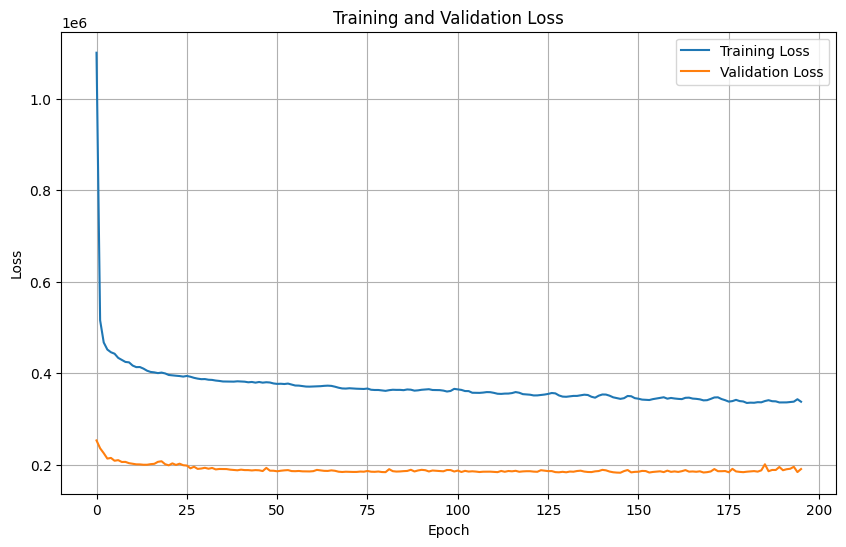

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

##  Save trained model

In [13]:
model.save('PaviaC_8x_saved_model.keras')

## Report the six types of results in terms of PSNR, SSIM, SAM, Correlation Coefficient, ERGAS, and RMSE.

In [14]:
def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  model.predict(X_test_lr)

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-08-01 11:09:37.104684: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
Average PSNR on the test set: 25.987543240189552
Average SSIM on the test set: 0.59644705
Average SAM on the test set (in degrees): 5.674434931308322
Average Correlation Coefficient on the test set: 0.7926207838469069
Average RMSE: 0.05083229


/usr/local/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib64/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
